In [1]:
# Import the library
import pandas as pd
import matplotlib.pyplot as plt

Check the different tables's basic information (Struture and the number)

In [2]:
"""
admission_df:
- ADMISSIONS.csv
- Every unique hospitalization for each patient in the database (defines HADM_ID)

callout_df:
- CALLOUT.csv
- Information regarding when a patient was cleared for ICU discharge and when the patient was actually discharged

icustays_df:
- ICUSTAYS.csv
- Every unique ICU stay in the database (defines ICUSTAY_ID)

patients_df:
- PATIENTS.csv
- Every unique patient in the database (defines SUBJECT_ID)

services_df:
- SERVICES.csv
- The clinical service under which a patient is registered

transfers_df:
- TRANSFERS.csv
- Patient movement from bed to bed within the hospital, including ICU admission and discharge
"""


admission_df = pd.read_csv('Data/ADMISSIONS.csv')
callout_df = pd.read_csv('Data/CALLOUT.csv')
#icustays_df = pd.read_csv('Data/ICUSTAYS.csv')
#patients_df = pd.read_csv('Data/PATIENTS.csv')
#services_df = pd.read_csv('Data/SERVICES.csv')
#transfers_df = pd.read_csv('Data/TRANSFERS.csv')


### The summary of the admission table.
##### MOST IMPORTANT INDEX:
- The SUBJECT_ID is the unique sign for each patient. We should based on the subject_ID to link the info of the each patient. 
#### Some consideration about the data

- Why some DISCHTIME is nagative ? 
- “Organ donor accounts are sometimes created for patients who died in the hospital. These are distinct hospital admissions with very short, sometimes negative lengths of stay. Furthermore, their DEATHTIME is frequently the same as the earlier patient admission’s DEATHTIME.” (“The admissions table | MIMIC”)

- Why should we treat the DIAGNOSIS CAREFULLY?
- "The diagnosis is usually assigned by the admitting clinician" means that when a patient is admitted to a hospital, the clinician will make an initial assumption which based on their experience or basic examinations, such as lab results. Therefore, different admitting clinicians may have different opinions about the patient’s condition.Systematic ontology refers to a standardized classification system for diseases. Such as the ICD (International Classification of Diseases),SNOMED CT（Systematized Nomenclature of Medicine - Clinical Terms, LOINC（Logical Observation Identifiers Names and Codes. We may observe some issues in this table:: 1. The one disease with the different names.  2. Different standard for one disease. 3. Without the uniform code which is hard for following analysis. 

#### Explaination of the different columns:
- SUBJECT_ID, HADM_ID
> Each row of this table contains a unique HADM_ID, which represents a single patient’s admission to the hospital. HADM_ID ranges from 1000000 - 1999999. It is possible for this table to have duplicate SUBJECT_ID, indicating that a single patient had multiple admissions to the hospital. The ADMISSIONS table can be linked to the PATIENTS table using SUBJECT_ID.
- ADMITTIME 
> provides the date and time the patient was admitted to the hospital

- DISCHTIME
> provides the date and time the patient was discharged from the hospital.

- DEATHTIME
> is only present if the patient died in-hospital, and is almost always the same as the patient’s __DISCHTIME__ (Note: There may contain some difference because of the typographical errors)

- ADMISSION_TYPE
> There are 3 types of the admission: ‘ELECTIVE’, ‘URGENT’, ‘NEWBORN’ or ‘EMERGENCY’.
__Emergency/urgent__  indicate unplanned medical care, and are often collapsed into a single category in studies. __Elective__ indicates a previously planned hospital admission. __NEWBORN__ means that the babies and mom will  get two different __HADM_ID__

- ADMISSION_LOCATION
> ADMISSION_LOCATION provides information about the previous location of the patient prior to arriving at the hospital. There are 9 possible values:
- EMERGENCY ROOM ADMIT
- TRANSFER FROM HOSP/EXTRAM 
- TRANSFER FROM OTHER HEALT  
- CLINIC REFERRAL/PREMATURE
- INFO NOT AVAILABLE
- TRANSFER FROM SKILLED NUR  
- TRSF WITHIN THIS FACILITY  
- HMO REFERRAL/SICK  
- PHYS REFERRAL/NORMAL DELI  

- HOSPITAL_EXPIRE_FLAG
> indicates whether the patient died within the given hospitalization. 1 indicates death in the hospital, and 0 indicates survival to hospital discharge.

- DIAGNOSIS
> column provides a preliminary, free text diagnosis for the patient on hospital admission.The diagnosis is usually assigned by the admitting clinician and does not use a systematic ontology.

- INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY
> The INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY columns describe patient demographics. These columns occur in the ADMISSIONS table as they are originally sourced from the admission, discharge, and transfers (ADT) data from the hospital database. The values occasionally change between hospital admissions (HADM_ID) for a single patient (SUBJECT_ID). This is reasonable for some fields (e.g. MARITAL_STATUS, RELIGION), but less reasonable for others (e.g. ETHNICITY).

- EDREGTIME, EDOUTTIME
> Time that the patient was registered and discharged from the emergency department.
 
For more details, please refer to the [MIMIC-III ADMISSION.CSV documentation](https://mimic.mit.edu/docs/iii/tables/admissions/).





In [33]:
"""Check the format of the admission table"""
admission_df.info()

"""Check the number of unique patients with their corresponding admission IDs"""
hospital_admissions_per_patient = admission_df.groupby('SUBJECT_ID')['HADM_ID'].nunique()

"""Check the number of patients whose number of admission IDs is greater than 1"""
multiple_hospital_admissions = (hospital_admissions_per_patient > 1).sum()
print(f"\nThe number of patients whose number of admission IDs is greater than 1: {multiple_hospital_admissions}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ROW_ID                58976 non-null  int64 
 1   SUBJECT_ID            58976 non-null  int64 
 2   HADM_ID               58976 non-null  int64 
 3   ADMITTIME             58976 non-null  object
 4   DISCHTIME             58976 non-null  object
 5   DEATHTIME             5854 non-null   object
 6   ADMISSION_TYPE        58976 non-null  object
 7   ADMISSION_LOCATION    58976 non-null  object
 8   DISCHARGE_LOCATION    58976 non-null  object
 9   INSURANCE             58976 non-null  object
 10  LANGUAGE              33644 non-null  object
 11  RELIGION              58518 non-null  object
 12  MARITAL_STATUS        48848 non-null  object
 13  ETHNICITY             58976 non-null  object
 14  EDREGTIME             30877 non-null  object
 15  EDOUTTIME             30877 non-null

The number of the failed DISCHTIME 0

The number of the failed ADMITTIME 0



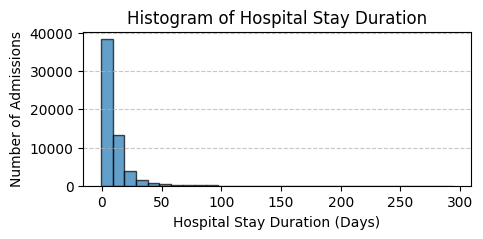

HOSPITAL_STAY_DAYS
-1        98
 0      2194
 1      3473
 2      5715
 3      5138
        ... 
 181       1
 191       1
 202       1
 206       1
 294       1
Name: count, Length: 162, dtype: int64


In [34]:
""" Calculate the length of a patient's stay in the hospital."""
# Convert the DISCHTIME and ADMITTIME from object to date time format
admission_df['DISCHTIME'] = pd.to_datetime(admission_df['DISCHTIME'], errors='coerce') 
admission_df['ADMITTIME'] = pd.to_datetime(admission_df['ADMITTIME'], errors='coerce')

# Check the number of failed conversions for DISCHTIME and ADMITTIME
fail_DISCHTIME = admission_df['DISCHTIME'].isna().sum()
print(f"The number of the failed DISCHTIME {fail_DISCHTIME}\n")
fail_ADMITTIME = admission_df['ADMITTIME'].isna().sum()
print(f"The number of the failed ADMITTIME {fail_ADMITTIME}\n")

# Get the lengths
admission_df['HOSPITAL_STAY_DAYS'] = (admission_df['DISCHTIME'] - admission_df['ADMITTIME']).dt.days
plt.figure(figsize=(5, 2))
plt.hist(admission_df['HOSPITAL_STAY_DAYS'].dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Hospital Stay Duration (Days)')
plt.ylabel('Number of Admissions')
plt.title('Histogram of Hospital Stay Duration')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
# Print the table about the hospital_stay_counts
hospital_stay_counts = admission_df['HOSPITAL_STAY_DAYS'].value_counts().sort_index()
print(hospital_stay_counts)

patients_negative_stay = admission_df[admission_df['HOSPITAL_STAY_DAYS'] == -1]


In [35]:
# Total death in the ADMISSION.CSV file
total_deaths = admission_df['HOSPITAL_EXPIRE_FLAG'].sum()
print(f"Total number of death in the ADMISSION.csv: {total_deaths}")

Total number of death in the ADMISSION.csv: 5854


In [36]:
# Different Diagnosis in the ADMISSION.csv
diagnosis_counts = admission_df['DIAGNOSIS'].value_counts().reset_index()
diagnosis_counts.columns = ['Diagnosis', 'Count']
# Calculate the mortality of the different Diagnosis
mortality_counts = admission_df[admission_df['HOSPITAL_EXPIRE_FLAG'] == 1]['DIAGNOSIS'].value_counts().reset_index()
mortality_counts.columns = ['Diagnosis', 'Mortality Count']

diagnosis_mortality_df = pd.DataFrame({
    'Diagnosis': diagnosis_counts['Diagnosis'],
    'Count': diagnosis_counts['Count'],
    'Mortality Count': diagnosis_counts.merge(mortality_counts, on='Diagnosis', how='left')['Mortality Count'].fillna(0).astype(int)
})
diagnosis_mortality_df['Mortality Rate (%)'] = (diagnosis_mortality_df['Mortality Count'] / diagnosis_mortality_df['Count']) * 100
diagnosis_mortality_df.head(11)

,Diagnosis,Count,Mortality Count,Mortality Rate (%)
0,NEWBORN,7823,62,0.792535
1,PNEUMONIA,1566,264,16.858238
2,SEPSIS,1184,267,22.550676
3,CONGESTIVE HEART FAILURE,928,126,13.577586
4,CORONARY ARTERY DISEASE,840,23,2.738095
5,CHEST PAIN,778,52,6.683805
6,INTRACRANIAL HEMORRHAGE,713,231,32.398317
7,ALTERED MENTAL STATUS,712,88,12.359551
8,GASTROINTESTINAL BLEED,686,57,8.309038
9,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,583,1,0.171527


In [37]:
# Observe the different ethnicities in the table
unique_ethnicities = admission_df['ETHNICITY'].value_counts()
print(unique_ethnicities)
# All of the data may contain the duplicate, should we remove them?


ETHNICITY
WHITE                                                       40996
BLACK/AFRICAN AMERICAN                                       5440
UNKNOWN/NOT SPECIFIED                                        4523
HISPANIC OR LATINO                                           1696
OTHER                                                        1512
ASIAN                                                        1509
UNABLE TO OBTAIN                                              814
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                                           85


### The summary of the callout table.
##### MOST IMPORTANT INDEX:
- The SUBJECT_ID is the unique sign for each patient. We should based on the subject_ID to link the basic info of the each patient. And the HADM_ID links about the patients' admission info.

#### Some consideration about the data
- Call out data is not available for all adult patients, as the data collection only began part way through the collection of the MIMIC database
- Call out data is never available for neonates (newborn)


#### Explaination of the different columns:
- SUBMIT_WARDID 
>  identifies the ward from which the request was submitted.
- SUBMIT_CAREUNIT 
> SUBMIT_CAREUNIT indicates whether the SUBMIT_WARDID corresponds to an ICU cost center, and if so, what type of ICU cost center.

- CURR_WARDID
> identifies the ward in which the patient resides when called out (i.e. prior to discharge/transfer).

- CURR_CAREUNIT
> indicates which ICU cost center the CURR_WARDID corresponds to (note: since all patients are being discharged from an ICU, all patients should reside in an ICU cost center).

- REQUEST_TELE, REQUEST_RESP, REQUEST_CDIFF, REQUEST_MRSA, REQUEST_VRE
> __REQUEST_MRSA__ means that the patient is colonized or infected with MRSA, a drug resistant source of hospital acquired infections.
> __REQUEST_TELE__ means the Telemetry which is always used Atrial Fibrillation or heart attack
> __REQUEST_RESP__ means the Respiratory Precautions which is always used in the TB or Flu
> __REQUEST_CDIFF__ means the Clostridioides difficile, C. diff which is easy to infect other person
> __REQUEST_VRE__ means that VRE（Vancomycin-Resistant Enterococcus）

- CALLOUT_STATUS
> indicates whether the call out is still active or not: if a call out is answered it should be flagged as inactive.

- CALLOUT_OUTCOME
> is either ‘Discharged’ or ‘Cancelled’, indicating whether the patient finally called out (i.e. discharged) or not.

- DISCHARGE_WARDID
> indicates the ward to which the patient was actually discharged. DISCHARGE_WARDID = 0 indicates home and other values correspond to distinct wards in the hospital

- ACKNOWLEDGE_STATUS
> ACKNOWLEDGE_STATUS indicates the response to the callout event: ‘Acknowledged’, ‘Revised’, ‘Unacknowledged’ or ‘Reactivated’.

- CREATETIME, UPDATETIME, ACKNOWLEDGETIME, OUTCOMETIME, FIRSTRESERVATIONTIME, CURRENTRESERVATIONTIME
> CREATETIME provides the time and date that the call out was initiated. UPDATETIME provides the last time at which the call out event was updated. ACKNOWLEDGETIME is the time at which the call out was first acknowledged. OUTCOMETIME is the time at which the CALLOUT_OUTCOME occurred. FIRSTRESERVATIONTIME and CURRENTRESERVATIONTIME provide information regarding ward reservations.


In [38]:
""" The basic info about the CallOut information"""
callout_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34499 entries, 0 to 34498
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ROW_ID                  34499 non-null  int64  
 1   SUBJECT_ID              34499 non-null  int64  
 2   HADM_ID                 34499 non-null  int64  
 3   SUBMIT_WARDID           34498 non-null  float64
 4   SUBMIT_CAREUNIT         5122 non-null   object 
 5   CURR_WARDID             34498 non-null  float64
 6   CURR_CAREUNIT           34498 non-null  object 
 7   CALLOUT_WARDID          34499 non-null  int64  
 8   CALLOUT_SERVICE         34499 non-null  object 
 9   REQUEST_TELE            34499 non-null  int64  
 10  REQUEST_RESP            34499 non-null  int64  
 11  REQUEST_CDIFF           34499 non-null  int64  
 12  REQUEST_MRSA            34499 non-null  int64  
 13  REQUEST_VRE             34499 non-null  int64  
 14  CALLOUT_STATUS          34499 non-null

In [51]:
# Explores different types of the care unit 
careUnit_count = callout_df['CURR_CAREUNIT'].value_counts()
print(careUnit_count)
"""
MICU: Medical Intensive Care Unit
SICU: Surgical Intensive Care Unit
CCU: Coronary Care Unit
CSRU: Cardiac Surgery Recovery Unit
TSICU: Trauma Surgical Intensive Care Unit
"""

# Focus on the special care requests 
special_care_counts = callout_df[['REQUEST_TELE', 'REQUEST_RESP', 'REQUEST_MRSA', 'REQUEST_VRE', 'REQUEST_CDIFF']].sum()

print('\n')
print(special_care_counts)



CURR_CAREUNIT
MICU     14015
SICU      6647
CSRU      5532
TSICU     4238
CCU       4066
Name: count, dtype: int64


REQUEST_TELE     19220
REQUEST_RESP       291
REQUEST_MRSA      3336
REQUEST_VRE       1395
REQUEST_CDIFF     1014
dtype: int64


In [54]:
""" Patients' outcone after they enter the ICU"""
outcome_count = callout_df['CALLOUT_OUTCOME'].value_counts()
print(outcome_count)
outcome_status = callout_df['CALLOUT_STATUS'].value_counts()
print('\n')
print(outcome_status)

# Analyzed the differnet type of the ICU outcome result 
outcome_ICU = callout_df.groupby(['CURR_CAREUNIT', 'CALLOUT_OUTCOME'])['HADM_ID'].count().unstack()
# Observe the patient successfully discharge rate
outcome_ICU['Discharge Rate'] = outcome_ICU['Discharged'] / (outcome_ICU['Discharged'] + outcome_ICU['Cancelled'])
print(outcome_ICU)

# Based on the result, all of the request has been solved and most of the patient successfully discharge.

CALLOUT_OUTCOME
Discharged    29965
Cancelled      4534
Name: count, dtype: int64


CALLOUT_STATUS
Inactive    34499
Name: count, dtype: int64
CALLOUT_OUTCOME  Cancelled  Discharged  Discharge Rate
CURR_CAREUNIT                                         
CCU                    542        3524        0.866699
CSRU                   763        4769        0.862075
MICU                  1937       12078        0.861791
SICU                   772        5875        0.883857
TSICU                  520        3718        0.877301


In [46]:
"""Find the corresponding code for different weird""" 
curr_ward = callout_df.groupby('CURR_WARDID',as_index=False)['CURR_CAREUNIT'].first()
print(curr_ward)

# Does the id means that the different ICU room number? Because they seems not unique corresponding to each type of the room


    CURR_WARDID CURR_CAREUNIT
0           2.0           CCU
1           3.0          SICU
2           4.0          MICU
3           7.0           CCU
4           8.0          SICU
5           9.0          SICU
6          12.0          CSRU
7          13.0           CCU
8          14.0         TSICU
9          15.0          MICU
10         17.0           CCU
11         18.0          MICU
12         23.0          MICU
13         24.0          MICU
14         25.0          MICU
15         27.0           CCU
16         28.0          MICU
17         29.0          MICU
18         31.0          SICU
19         32.0           CCU
20         33.0          SICU
21         36.0          SICU
22         39.0          MICU
23         40.0          MICU
24         41.0          MICU
25         44.0         TSICU
26         45.0          MICU
27         48.0          SICU
28         49.0         TSICU
29         50.0          MICU
30         51.0          MICU
31         52.0          MICU
32        

### The summary of the chartevents  table.
##### MOST IMPORTANT INDEX:
- Some items are duplicated between the labevents and chartevents tables. In cases where there is disagreement between measurements, labevents should be taken as the ground truth.

#### Some consideration about the data
- Will the data such as the itemID also as the part of the free text?


#### Explaination of the different columns:
- ITEMID 
>  Identifier for a single measurement type in the database. Each row associated with one ITEMID (e.g. 212) corresponds to an instantiation of the same measurement (e.g. heart rate).
- SUBMIT_CAREUNIT 
> SUBMIT_CAREUNIT indicates whether the SUBMIT_WARDID corresponds to an ICU cost center, and if so, what type of ICU cost center.

- CURR_WARDID
> identifies the ward in which the patient resides when called out (i.e. prior to discharge/transfer).

- CURR_CAREUNIT
> indicates which ICU cost center the CURR_WARDID corresponds to (note: since all patients are being discharged from an ICU, all patients should reside in an ICU cost center).

- REQUEST_TELE, REQUEST_RESP, REQUEST_CDIFF, REQUEST_MRSA, REQUEST_VRE
> __REQUEST_MRSA__ means that the patient is colonized or infected with MRSA, a drug resistant source of hospital acquired infections.
> __REQUEST_TELE__ means the Telemetry which is always used Atrial Fibrillation or heart attack
> __REQUEST_RESP__ means the Respiratory Precautions which is always used in the TB or Flu
> __REQUEST_CDIFF__ means the Clostridioides difficile, C. diff which is easy to infect other person
> __REQUEST_VRE__ means that VRE（Vancomycin-Resistant Enterococcus）

- CALLOUT_STATUS
> indicates whether the call out is still active or not: if a call out is answered it should be flagged as inactive.

- CALLOUT_OUTCOME
> is either ‘Discharged’ or ‘Cancelled’, indicating whether the patient finally called out (i.e. discharged) or not.

- DISCHARGE_WARDID
> indicates the ward to which the patient was actually discharged. DISCHARGE_WARDID = 0 indicates home and other values correspond to distinct wards in the hospital

- ACKNOWLEDGE_STATUS
> ACKNOWLEDGE_STATUS indicates the response to the callout event: ‘Acknowledged’, ‘Revised’, ‘Unacknowledged’ or ‘Reactivated’.

- CREATETIME, UPDATETIME, ACKNOWLEDGETIME, OUTCOMETIME, FIRSTRESERVATIONTIME, CURRENTRESERVATIONTIME
> CREATETIME provides the time and date that the call out was initiated. UPDATETIME provides the last time at which the call out event was updated. ACKNOWLEDGETIME is the time at which the call out was first acknowledged. OUTCOMETIME is the time at which the CALLOUT_OUTCOME occurred. FIRSTRESERVATIONTIME and CURRENTRESERVATIONTIME provide information regarding ward reservations.


In [58]:
note_event_df = pd.read_csv('Data/NOTEEVENTS.csv', low_memory=False)
note_event_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [59]:
print(note_event_df['TEXT'].iloc[1])

Admission Date:  [**2118-6-2**]       Discharge Date:  [**2118-6-14**]

Date of Birth:                    Sex:  F

Service:  MICU and then to [**Doctor Last Name **] Medicine

HISTORY OF PRESENT ILLNESS:  This is an 81-year-old female
with a history of emphysema (not on home O2), who presents
with three days of shortness of breath thought by her primary
care doctor to be a COPD flare.  Two days prior to admission,
she was started on a prednisone taper and one day prior to
admission she required oxygen at home in order to maintain
oxygen saturation greater than 90%.  She has also been on
levofloxacin and nebulizers, and was not getting better, and
presented to the [**Hospital1 18**] Emergency Room.

In the [**Hospital3 **] Emergency Room, her oxygen saturation was
100% on CPAP.  She was not able to be weaned off of this
despite nebulizer treatment and Solu-Medrol 125 mg IV x2.

Review of systems is negative for the following:  Fevers,
chills, nausea, vomiting, night sweats, change in we

Report
